In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
train_ds = datasets.MNIST(root="./mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.MNIST(root="./mnist", train=False, transform=transforms.ToTensor())

In [3]:
n_train = len(train_ds)

from torch.utils.data import random_split

torch.manual_seed(1)

train_ds, val_ds = random_split(train_ds, [int(0.85*n_train), n_train-int(0.85*n_train)])

In [4]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=256,shuffle=False, num_workers=2, persistent_workers=True)
test_loader = DataLoader(train_ds, batch_size=256, shuffle=False, num_workers=2, persistent_workers=True)

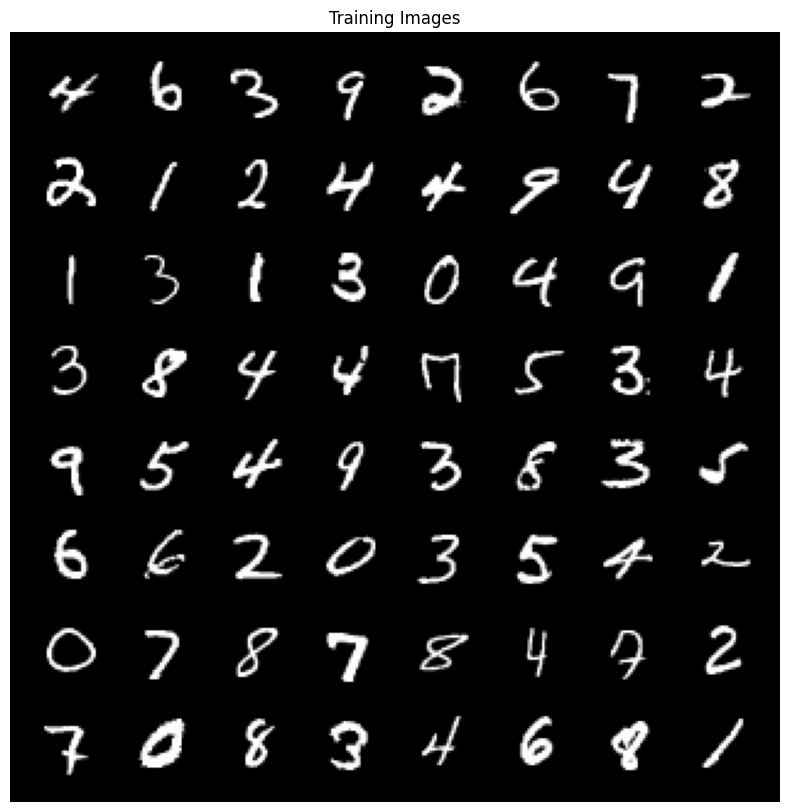

In [5]:
import torchvision
for images, labels in train_loader:
    break

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(torchvision.utils.make_grid(
        images[:64],
        padding=10,
        normalize=True
    ),
    (1,2,0))
)
plt.show()

In [6]:
import lightning as L

In [7]:
import torch.nn.functional as F
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, y_true = batch
        logits = self(features)
        loss = F.cross_entropy(logits, y_true)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        features, y_true = batch
        logits = self(features)
        loss = F.cross_entropy(logits, y_true)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=self.learning_rate)
        return optimizer

In [8]:
def accuracy_fn(model, dataloader):
    correct = 0
    total = 0
    model = model.eval()
    for features, labels in dataloader:
        with torch.inference_mode():
            logits = model(features)
        y_pred = torch.argmax(logits, dim=1)
        compare = labels == y_pred
        correct += torch.sum(compare)
        total += len(compare)
    return correct/total


class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=64, hidden_layers = 2):
        super().__init__()
        layers = [nn.Linear(in_features=in_features, out_features=hidden_units), nn.ReLU()]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers.append(nn.Linear(hidden_units, out_features))

        self.stack = nn.Sequential(
            *layers
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.stack(x)

mlp = MLP(in_features=28*28, out_features=10, hidden_units=32, hidden_layers=1)

lightning_model = LightningModel(model=mlp, learning_rate=0.01)

trainer = L.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto"
)

trainer.fit(model=lightning_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

train_acc = accuracy_fn(mlp, train_loader)
val_acc = accuracy_fn(mlp, val_loader)
test_acc = accuracy_fn(mlp, test_loader)

print(f"Train accuracy: {train_acc*100:.3f}%"
      f" | Validation accuracy: {val_acc*100:.3f}%"
      f" | Test accuracy: {test_acc*100:.3f}%")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 26.5 K
-------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


Train accuracy: 98.020% | Validation accuracy: 95.922% | Test accuracy: 98.020%
